In [1]:
import reaction as rxn

In [2]:
#Reagents
ini = rxn.Reagent(160,"Ini",1)
inirad = rxn.Reagent(ini.mw/2,ini.name+"*",0)
mono = rxn.Reagent(100.12,"M",100)

poly = rxn.Reagent(0,"P",0)
polyrad = rxn.Reagent(poly.mw,poly.name+"*",0)

In [169]:
#Reactions
from  functools import partial
import random

def growfunc(particles,ed1,ed2,pd1,is_nan_array=None,first_nans=None,randoms=None):
    
    if is_nan_array is None:
        is_nan_array=np.isnan(particles) 
        first_nans = np.argmax(is_nan_array,1)
    if first_nans is None:    
        first_nans = np.argmax(is_nan_array,1) 
        
    if randoms is None or randoms.size<10:
        randoms = np.random.rand(10**4)
    first_nan_1=first_nans[ed1.position]#
    
    
    if first_nan_1 == 0:
        if is_nan_array[ed1.position][-1]:
            return is_nan_array,first_nans,randoms
        first_nan_1 = is_nan_array.shape[1]
        
    ran,randoms=randoms[-1],randoms[:-1]
    i1 = int(first_nan_1 * ran)
    particles[ed1.position][i1],particles[ed1.position][first_nan_1-1] = particles[ed1.position][first_nan_1-1],particles[ed1.position][i1]
    mw1 = particles[ed1.position][first_nan_1-1]
    
    particles[ed1.position][first_nan_1-1] = np.nan
    is_nan_array[ed1.position][first_nan_1-1] = True
    first_nans[ed1.position] -= 1 #
    
    first_nan_2=first_nans[ed2.position]#
    
    if first_nan_2 == 0:
        if is_nan_array[ed2.position][-1]:
            particles[ed1.position][first_nan_1-1] = mw1
            is_nan_array[ed1.position][first_nan_1-1]=False
            first_nans[ed1.position] += 1
            return is_nan_array,first_nans,randoms
        first_nan_2 = is_nan_array.shape[1]
        
    ran,randoms=randoms[-1],randoms[:-1]
    i2 = int(first_nan_2 * ran)
    particles[ed2.position][i2],particles[ed2.position][first_nan_2-1] = particles[ed2.position][first_nan_2-1],particles[ed2.position][i2]
    mw2 = particles[ed2.position][first_nan_2-1]
    
    particles[ed2.position][first_nan_2-1] = np.nan
    is_nan_array[ed2.position][first_nan_2-1] = True
    first_nans[ed2.position] -= 1
    
    first_nan_3=first_nans[pd1.position]
    
    particles[pd1.position][first_nan_3] = mw1+mw2
    is_nan_array[pd1.position][first_nan_3] = False
    first_nans[pd1.position] += 1
    
    return is_nan_array,first_nans,randoms
    

ini_deg = rxn.Reaction([(1,ini)],[(2,inirad)],k1=1,k2=0,name="inideg")
initiation = rxn.Reaction([(1,inirad),(1,mono)],[(1,polyrad)],k1=0.8,name="ini",rxnfunc=partial(growfunc,ed1=inirad,ed2=mono,pd1=polyrad))
grow = rxn.Reaction([(1,polyrad),(1,mono)],[(1,polyrad),],k1=0.5,name="grow",rxnfunc=partial(growfunc,ed1=polyrad,ed2=mono,pd1=polyrad))
exit1= rxn.Reaction([(2,polyrad)],[(1,poly)],k1=0.2,name="ex1",rxnfunc=partial(growfunc,ed1=polyrad,ed2=polyrad,pd1=poly))
exit2= rxn.Reaction([(1,polyrad),(1,inirad)],[(1,poly)],name="ex2",k1=0.2,rxnfunc=partial(growfunc,ed1=polyrad,ed2=inirad,pd1=polyrad))


In [170]:
#create reaction set
polymerization = rxn.ReactionSet([ini_deg,initiation,grow,exit1,exit2])
print(polymerization)

inideg: Ini --> 2 Ini* (1)
ini: Ini* + M --> P* (0.8)
grow: P* + M --> P* (0.5)
ex1: 2 P* --> P (0.2)
ex2: P* + Ini* --> P (0.2)


In [171]:
#get diff equations
polymerization.print_diff_equations(k_as_number=True)

In [172]:
#solve kinetics
e = polymerization.solve_kinetics(time=20,min_resolution=0.01)


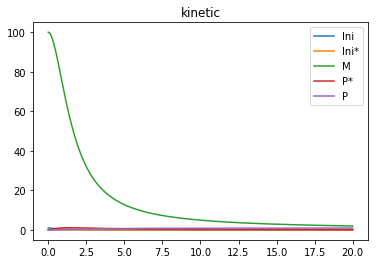

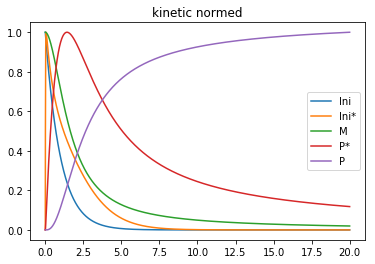

In [173]:
polymerization.plot_kinetics(add_normed=True)

In [174]:
def differentiate(x,y):
    dy = np.zeros(y.shape,np.float)
    dy[0:-1] = np.diff(y) / np.diff(x)
    dy[-1] = (y[-1] - y[-2])/(x[-1] - x[-2])
    return dy

In [175]:
from massplotter import mass_plot as plot
import numpy as np

In [186]:
ppM=10**5
diff_t = np.diff(polymerization.kinetic_solve.t)

rxncounts=np.zeros((len(polymerization.kinetic_solve.t),len(polymerization.reactions),2))
rxnrates=np.zeros((len(polymerization.kinetic_solve.t),len(polymerization.reactions),2))

for i in range(len(polymerization.kinetic_solve.y[0])-1):
    reacts=dict(zip(polymerization.reacts, polymerization.kinetic_solve.y[0:,i]))
    rxnrates[i]=np.concatenate([r.get_rate(reacts) for r in polymerization.reactions]).reshape(-1,2)
    rxncounts[i]= rxnrates[i]*diff_t[i]*ppM

rxncounts=np.array(rxncounts).transpose(1, 0, 2)

for c in rxncounts:
    c[:-1]=c[:-1]+np.diff(c,axis=0)/2
rxncounts = rxncounts.astype(int)

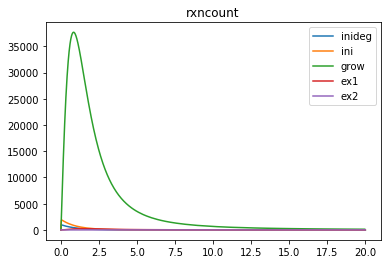

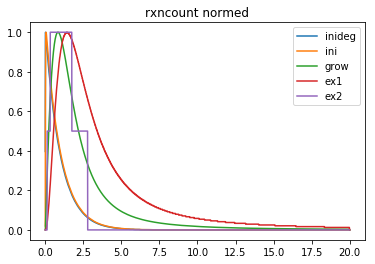

In [187]:
plot(polymerization.kinetic_solve.t,rxncounts[:,:,0], title="rxncount",labels=polymerization.reactions)
plot(polymerization.kinetic_solve.t,rxncounts[:,:,0], title="rxncount normed",norm=True,labels=polymerization.reactions)

In [188]:

%load_ext line_profiler
def toprof():
    print(1)
%lprun -f print toprof()

Timer unit: 5.14057e-07 s

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
1


In [189]:
maxc=max(*[r.c0 for r in polymerization.reacts])
for i in range(len(polymerization.reacts)):
    polymerization.reacts[i].position = i

particles=np.empty((len(polymerization.reacts),int(maxc*ppM*1.01))) * np.nan
for react in polymerization.reacts:
    particles[react.position][0:react.c0*ppM] = react.mw
trxn = rxncounts.transpose(1,0,2)
isnan = None 
first_nans = None
randoms = None
pcount=np.zeros((trxn.shape[0],trxn.shape[1]))

for timepoint in range(trxn.shape[0]):
    for reactionpoint in range(trxn.shape[1]):
        reaction = polymerization.reactions[reactionpoint]
        for t in range(trxn[timepoint][reactionpoint][0]):
                isnan,first_nans,randoms = reaction.rxnfunc(particles,is_nan_array=isnan,first_nans=first_nans,randoms=randoms)
    
        pcount[timepoint] = first_nans

In [190]:
particles

array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [   80.  ,    80.  ,    80.  , ...,      nan,      nan,      nan],
       [  100.12,   100.12,   100.12, ...,      nan,      nan,      nan],
       [ 7589.  ,  8590.2 , 11193.32, ...,      nan,      nan,      nan],
       [  560.48,   660.6 ,   660.6 , ...,      nan,      nan,      nan]])

In [191]:
pcount

array([[9.961200e+04, 7.380000e+02, 9.999962e+06, 3.800000e+01,
        0.000000e+00],
       [9.878800e+04, 1.910000e+03, 9.999392e+06, 5.140000e+02,
        0.000000e+00],
       [9.782600e+04, 2.656000e+03, 9.997728e+06, 1.692000e+03,
        0.000000e+00],
       ...,
       [0.000000e+00, 6.440000e+02, 1.999100e+05, 1.522400e+04,
        9.186200e+04],
       [0.000000e+00, 6.440000e+02, 1.998930e+05, 1.522400e+04,
        9.186200e+04],
       [0.000000e+00, 6.440000e+02, 1.998930e+05, 1.522400e+04,
        9.186200e+04]])

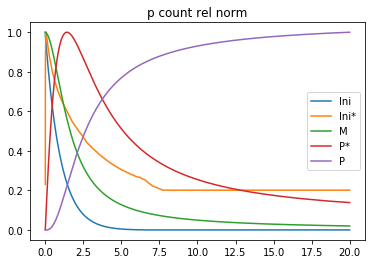

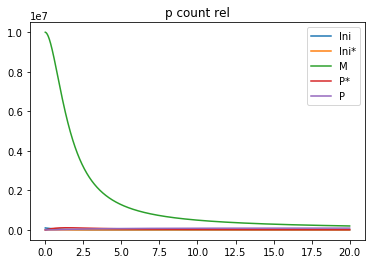

In [192]:
from massplotter import mass_plot as plot
plot(polymerization.kinetic_solve.t,pcount.transpose(), title="p count rel norm",norm=True,labels=polymerization.reacts)
plot(polymerization.kinetic_solve.t,pcount.transpose(), title="p count rel",labels=polymerization.reacts)


11979 9289 1.2895393752523643


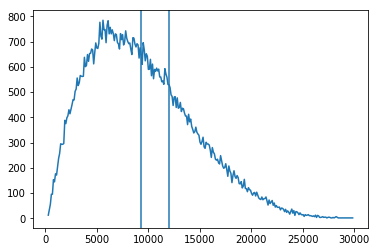

In [197]:
reac=poly
res=mono.mw
a=(np.sort(particles[reac.position][~np.isnan(particles[reac.position])])/res).astype(int)*res
unique, counts = np.unique(a, return_counts=True)

mn=sum(unique*counts)/sum(counts)
mw=sum(unique*counts*unique)/sum(unique*counts)
d=mw/mn
print(int(mw),int(mn),d)

plt.plot(unique[:],counts[:])
plt.axvline(x=mn)
plt.axvline(x=mw)
plt.show()

Ini
Ini*
M
P*
P
inideg
ini
grow
ex1
ex2
[[-1.  0.  0.  0.  0.]
 [ 2. -1.  0.  0. -1.]
 [ 0. -1. -1.  0.  0.]
 [ 0.  1.  0. -2. -1.]
 [ 0.  0.  0.  1.  1.]]
-1.0 0.0 0.0 0.0 0.0 -0.9996467082126997
2.0 -1.0 0.0 0.0 -1.0 1.94381724940738
0.0 -1.0 -1.0 0.0 0.0 -0.05613273330022758
0.0 1.0 0.0 -2.0 -1.0 0.05547616145645896
0.0 0.0 0.0 1.0 1.0 2.7807301245322122e-09


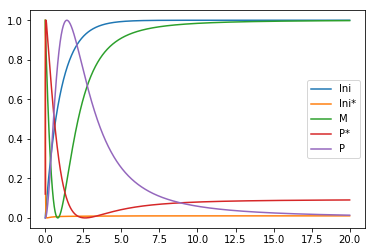

In [184]:
rates = np.zeros(len(polymerization.reactions),np.float)
d = np.array([differentiate(e.t,e.y[i]) for i in range(len(e.y))])
for i in range(len(d)):
    plt.plot(e.t,(d[i]-d[i].min())/(d[i]-d[i].min()).max(),label=str(polymerization.reacts[i]))
plt.legend()
#print(d)
diffarray = np.zeros((len(polymerization.reactions),len(polymerization.reacts)))
for r in polymerization.reacts:
    print(r)
for i in range(len(polymerization.reactions)):
    for n, reac in polymerization.reactions[i].educts:
        diffarray[i][polymerization.reacts_ord[reac]] = diffarray[i][polymerization.reacts_ord[reac]] - n
    for n, reac in polymerization.reactions[i].products:
        diffarray[i][polymerization.reacts_ord[reac]] = diffarray[i][polymerization.reacts_ord[reac]] + n
    
    print(polymerization.reactions[i])
print(diffarray.transpose())
    #n1*r1...ni*ri= d reac i

for i in range(len(diffarray.transpose())):
    print(" ".join([str(diffarray.transpose()[i][j]) for j in range(len(diffarray.transpose()[i]))]) + " "+str(d[0:,0][i]))

    